# One-dimensional maps

Computer programs are an indispensable tool in the analysis and applications of dynamical systems. In this notebook, we use Python to explore the properties of one-dimensional maps studied in class.

## Preliminaries

We import a few modules that provide useful functionality for modeling dynamical systems.

In [1]:
%matplotlib ipympl

%load_ext nb_mypy
%nb_mypy On

Version 1.0.5


In [17]:
import matplotlib.pyplot as plt
import numpy as np 

from fractions import Fraction
from itertools import accumulate, islice, repeat, zip_longest
from ipywidgets import interact
from more_itertools import take
from nptyping import NDArray, Shape, Double
from typing import Callable, Generator, Iterable, Iterator, Tuple, TypeVar

## Defining maps 

Let $X$ be a subset of the real line such as an interval. We model a map $f: X \to X$ as a Python function `f` with signature `f(x:X) -> X`. Here, `X` is a *type variable* that indicates our computational representation of the real numbers. For our purposes, it will be sufficient to set `X` to either a `float` (64-bit floating point number), an `NDArray` of floats, or a `Fraction` (rational number). We also introduce a type variable `F` that represents functions with that signature (in Python, the data type for functions is `Callable`). To build `f`, we write functions that take as inputs the parameter of our model and return the dynamical map `f` as an output. Below are examples for the linear map, $f(x) = ax$, and the logistic map, $g(x) = ax(1-x)$, that we studied in class. Both of these maps have a single real parameter $a$, so our Python code takes as input a single variable `a` (of type `X`), and returns as output a function of type `F`. We also define the identity map for convenience when making cobweb plots.

Try it out yourself for the map of your choice.  

In [3]:
X = float | Fraction | NDArray[Shape['*, ...'], Double]
F = Callable[[X], X]

### Dynamical maps

Within the body of each function, we define `f` using a `lambda` expression&mdash;this is Python's way of defining small anonymous functions.

In [4]:
def identity_map() -> F:
    f = lambda x: x
    return f


def linear_map(a: X) -> F:
    f = lambda x: a * x
    return f


def logistic_map(a: X) -> F:
    f = lambda x: a * x * (1 - x)
    return f

Now that we have our dynamical maps, we can build them for different parameter values, and evaluate them at different points in $X$: 

In [5]:
idm = identity_map()
lin = linear_map(2) # linear map with parameter 2 
logi = logistic_map(2) # logistic map with parameter 2 

x = 0.5 # evaluation point

print(idm(x))
print(lin(x))
logi((x))

0.5
1.0


0.5

We can also make simple plots of our maps:

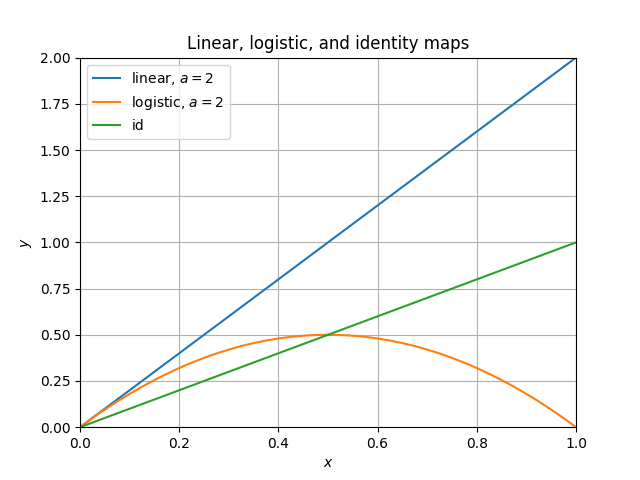

In [6]:
a_lin = 2 # parameter for linear map
a_logi = 2 # parameter for logistic map
xs = np.linspace(0.0, 1.0, num=100) # generate an equispaced grid of evaluation points in the unit interval

i_fig = 1
if plt.fignum_exists(i_fig):
    plt.close(i_fig)
    
fig, ax = plt.subplots(num=i_fig)
ax.plot(xs, lin(xs), label='linear, $a = %s$' % str(a_lin))
ax.plot(xs, logi(xs), label='logistic, $a = %s$' % str(a_logi))
ax.plot(xs, idm(xs), label='id')
ax.set_xlim(0, 1)
ax.set_ylim(0, 2)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title('Linear, logistic, and identity maps')
ax.grid(True)
ax.legend()

## Iterating maps

A primary goal in dynamical systems theory is to study the properties of maps $f: X \to X$ under iteration. Defining $f^2 = f \circ f $, $f^3 = f \circ f \circ f $, $\ldots$, where $\circ$ denotes map composition (i.e., $f\circ g(x) = f(g(x))$), we are interested in characterizing the behavior of $f^k$ as $k$ increases. Python provides us with a variety of tools to build iterated sequences of functions such as `f` using `Iterator` data types. A nice property of `Iterator` types is that they allow us to encode formally infinite sequences. Such sequences are "lazy", i.e., the terms evaluated only when needed, so as long as our computer has enough memory we can generate at will any finite number of terms. 

In [14]:
def compose(f: F, g: F) -> F:
    """Composition of maps"""
    h = lambda x: f(g(x))
    return h

def iterate(f: F) -> Iterator[F]:
    """Iterated composition of maps"""
    itf = accumulate(repeat(f), compose, initial=identity_map())
    return itf

Let's explore how the first few iterations of the linear and logistic map look like.

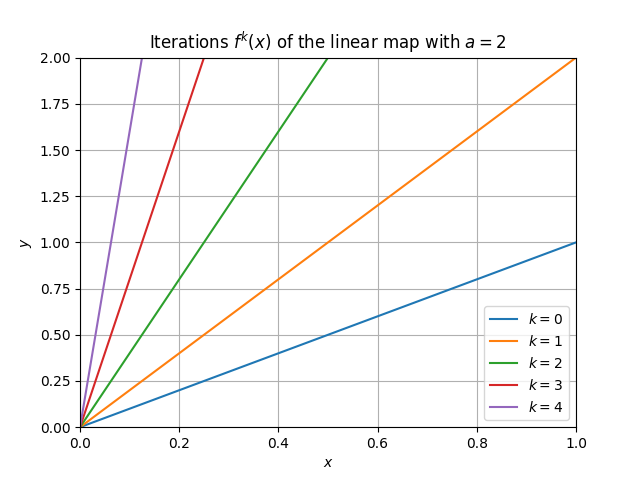

In [8]:
i_fig = 2
if plt.fignum_exists(i_fig):
    plt.close(i_fig)
    
fig, ax = plt.subplots(num=i_fig)
k = 0
for f in take(5, iterate(lin)):
    plt.plot(xs, f(xs), label='$k = %s$' % str(k))
    k += 1 
ax.set_xlim(0, 1)
ax.set_ylim(0, 2)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title('Iterations $f^k(x)$ of the linear map with $a = %s$' % str(a_lin))
ax.grid(True)
ax.legend()

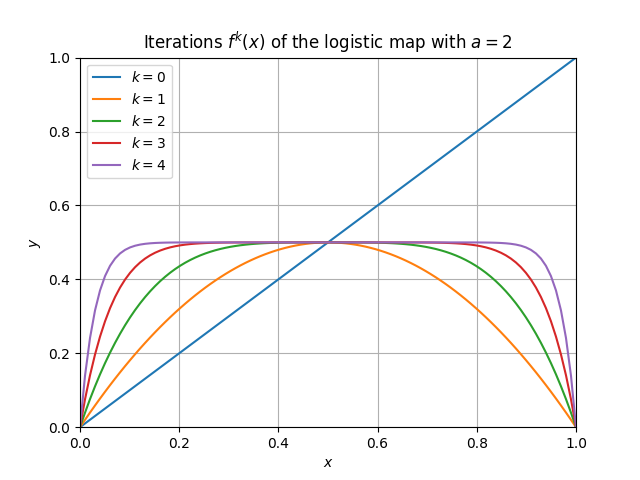

In [9]:
i_fig = 3
if plt.fignum_exists(i_fig):
    plt.close(i_fig)
    
fig, ax = plt.subplots(num=i_fig)
k = 0
for f in take(5, iterate(logi)):
    plt.plot(xs, f(xs), label='$k = %s$' % str(k))
    k += 1 
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title('Iterations $f^k(x)$ of the logistic map with $a = %s$' % str(a_lin))
ax.grid(True)
ax.legend()

## Computing orbits

Using the iterates $f^k$ we can now compute orbits of points in $X$ under the dynamics. Recall that the orbit of a point $x \in X$ under a map $f: X \to X$ is the set $O_x = \{ x, f(x), f^2(x), \ldots\}$. As in the case of the sequence $\{ \mbox{Id}, f, f^2, \ldots\}$, we represent $O_x$ as a formally infinite `Generator` object, from which we can take elements whenever we wish to access them. The new ingredient that we use here is a function `apply_at` that represents evaluation of functions defined on $X$. 

In [13]:
def orbit(x0: X, f: F) -> Generator[X, None, None]:
    """Orbit of a point under iterated application of a map."""
    x = x0
    while True:
        yield x
        x = f(x)

Let's use these functions to compare the orbits of a point $x$ near 0 under the linear and logistic maps. 

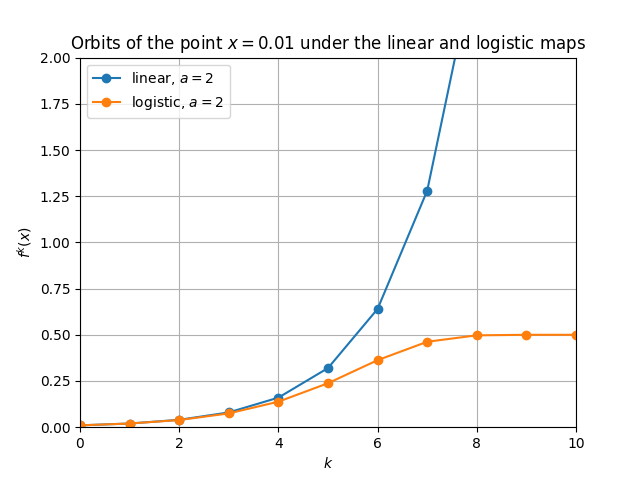

In [15]:
a = 2 # map parameter
x = 0.01 # initial condition
n = 11 # number of iterates

ks = range(n)

i_fig = 4
if plt.fignum_exists(i_fig):
    plt.close(i_fig)
fig, ax = plt.subplots(num=i_fig)
ax.plot(ks, take(n, orbit(x, linear_map(a))), 'o-', label='linear, $a = %s$' % str(a))
ax.plot(ks, take(n, orbit(x, logistic_map(a))), 'o-', label='logistic, $a = %s$' % str(a))
ax.set_xlim(0, n - 1)
ax.set_ylim(0, 2)
ax.set_xlabel('$k$')
ax.set_ylabel('$f^k(x)$')
ax.set_title('Orbits of the point $x = %s$ under the linear and logistic maps' % str(x))
ax.grid(True)
ax.legend()

## Cobweb plots

Using our computational representation of orbits, we can generate cobweb plots. The function `cobweb` computes the coordinates of the points needed to make a cobweb plot.

In [20]:
def imerge(a: Iterable[X], b: Iterable[X]) -> Iterator[X]:
    """Staggered merge of two iterables"""
    for i, j in zip_longest(a, b):
        yield i
        yield j
        
        
def cobweb(x: X, f: F) -> Tuple[Iterator[X], Iterator[X]]:
    """Pair of iterators giving (x, y) coordinates for cobweb plot"""
    orb1 = orbit(x, f)
    orb2 = orbit(x, f)
    x_coords = imerge(orb1, orb2)
    orb1 = orbit(x, f)
    orb2 = islice(orbit(x, f), 1, None)
    y_coords = imerge(orb1, orb2)
    return x_coords, y_coords

Below, we make cobweb plots for the orbits of the linear and logistic map shown in the previous figure.

Text(0.5, 1.0, 'Cobweb plot for the logistic map with $a = 2$')

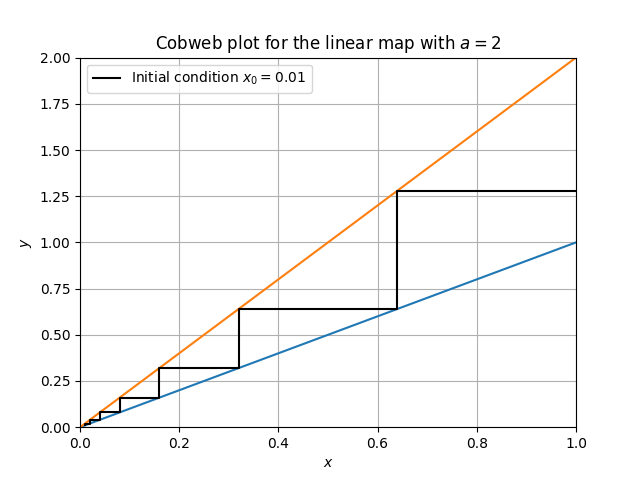

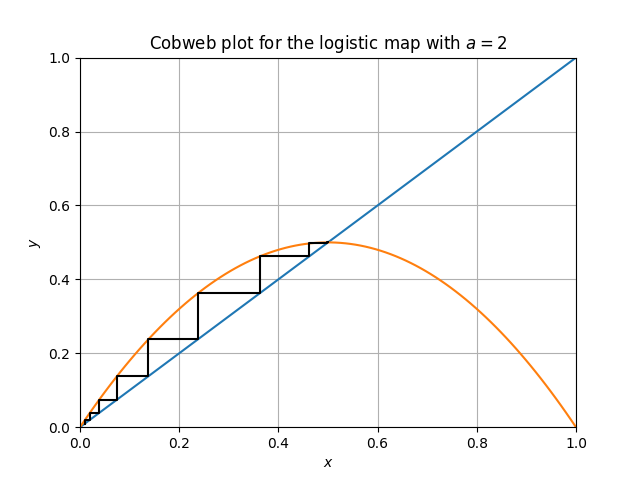

In [21]:
xs = np.linspace(0.0, 1.0, num=100) # generate an equispaced grid of evaluation points in the unit interval

# Linear map
cx, cy = cobweb(x, linear_map(a))
x_coords = take(2 * n, cx)
y_coords = take(2 * n, cy)

i_fig = 5
if plt.fignum_exists(i_fig):
    plt.close(i_fig)
fig, ax = plt.subplots(num=i_fig)
ax.plot(xs, xs)
ax.plot(xs, linear_map(a)(xs))
ax.plot(x_coords, y_coords,'k-', label='Initial condition $x_0 = %s$' % str(x))
ax.set_xlim(0, 1)
ax.set_ylim(0, 2)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.grid(True)
plt.title('Cobweb plot for the linear map with $a = %s$' % str(a))
plt.legend()

# Logistic map
cx, cy = cobweb(x, logistic_map(a))
x_coords = take(2 * n, cx)
y_coords = take(2 * n, cy)

i_fig = 6
if plt.fignum_exists(i_fig):
    plt.close(i_fig)
fig, ax = plt.subplots(num=i_fig)
ax.plot(xs, xs)
ax.plot(xs, logistic_map(a)(xs))
ax.plot(x_coords, y_coords,'k-', label='Initial condition $x_0 = %s$' % str(x))
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.grid(True)
plt.title('Cobweb plot for the logistic map with $a = %s$' % str(a))